# Introdução 

Esse notebook tem o objetivo de implementar o TSMOM do  Moskowitz.

![Equação do TSMOM](images/tsmom_eq.jpeg)

Em resumo a equação final do TSMOM do Moskowitz pode ser dividida nos seguintes tópicos: 
- O cálculo do momento do ativo
- Peso do ativo na carteira.
- Rendimento da estratégia

Cálculo do Momento: Calcula-se o retorno do periodo desejado (no caso da imagem os ultimos 12 meses), e com o retorno e mãos retira-se o sinal, tomando assim uma posição de vendido ou comprado.

O peso no portifolio: Risco buscado no investimento (no caso da imagem 20%), dividido pelo desvio padrão exponencial.

Rendimento da estratégia: Com a posição e peso calculados, calcula-se o rendimento que cada ativo teve no próximo perído. E para simplificar a alocação (não utilizar a matriz de covarianças) é calculado a média dos retornos de cada ativo, e esse será o rendimento da carteira.

# Importação

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dados


In [2]:
def prepare_yahoo_df(df):
    """
     Constroi o dataframe da maneira utilizada nas demais funções
    """

    close_df = df["Close"]
    close_df.columns = df["Close"].columns + "_close"

    high_df = df["High"]
    high_df.columns = df["High"].columns + "_high"

    low_df = df["Low"]
    low_df.columns = df["Low"].columns + "_low"

    open_df = df["Open"]
    open_df.columns = df["Open"].columns + "_open"

    volume_df = df["Volume"]
    volume_df.columns = df["Volume"].columns + "_volume"

    open_int_df = df["Adj Close"]
    open_int_df.columns = df["Adj Close"].columns + "_open_int"

    df2 = pd.concat([close_df, high_df, low_df, open_df,
                     volume_df, open_int_df], axis=1)

    return df2


from pandas_datareader import data

tickers = ['PETR4.SA', 'ITUB4.SA', 'VALE3.SA', 'MGLU3.SA', 'ABEV3.SA', 'RENT3.SA','OIBR3.SA']

df = data.DataReader (tickers,
                        start='2012-1-1',
                        end='2020-1-1',
                        data_source='yahoo')

df = prepare_yahoo_df(df)

/home/leme/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
def import_data(csv): 
    
    df = pd.read_csv(csv)
    df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.drop('date', axis=1)
    
    close_columns = []
    high_columns = []
    low_columns = []
    open_columns = []
    volume_columns = []
    open_int_columns = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    close_df = df[close_columns]
    high_df = df[high_columns]
    low_df = df[low_columns]
    open_df = df[open_columns]
    volume_df = df[volume_columns]
    open_int_df = df[open_int_columns]
    
    return [close_df, high_df, low_df, open_df, volume_df, open_int_df]

In [4]:
close_df, high_df, low_df, open_df, volume_df, open_int_df = import_data("data.csv")

close_df.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-21,42.81,143.90,2468.0,67.537,220.54,20.06,112.848,88.1480,3054.57,1464.26,...,72.14,4614.72,163.364,75.10,11237.36,5618.6,16474.0,1464.92,82.26,7704.9
1999-06-22,43.12,143.72,2421.0,67.537,222.69,20.20,113.002,88.1247,2984.70,1452.69,...,71.50,4536.94,166.007,74.87,11138.79,5586.4,16387.0,1453.39,82.11,7702.8
1999-06-23,43.39,142.89,2304.0,67.507,220.19,20.26,113.057,88.1060,3006.66,1445.15,...,74.32,4558.54,165.846,74.47,11119.07,5536.9,16262.0,1445.85,81.88,7601.4
1999-06-24,43.42,143.63,2227.0,67.497,222.81,20.29,112.419,88.0781,2952.09,1434.93,...,73.67,4528.30,162.323,73.86,10914.04,5466.2,16225.0,1435.62,81.59,7486.8
1999-06-25,43.64,143.52,2221.0,67.824,221.30,20.42,112.144,88.0781,2948.10,1430.89,...,74.08,4562.87,162.963,74.17,10921.93,5478.0,16229.0,1431.52,81.66,7511.3


## Visualização dos dados

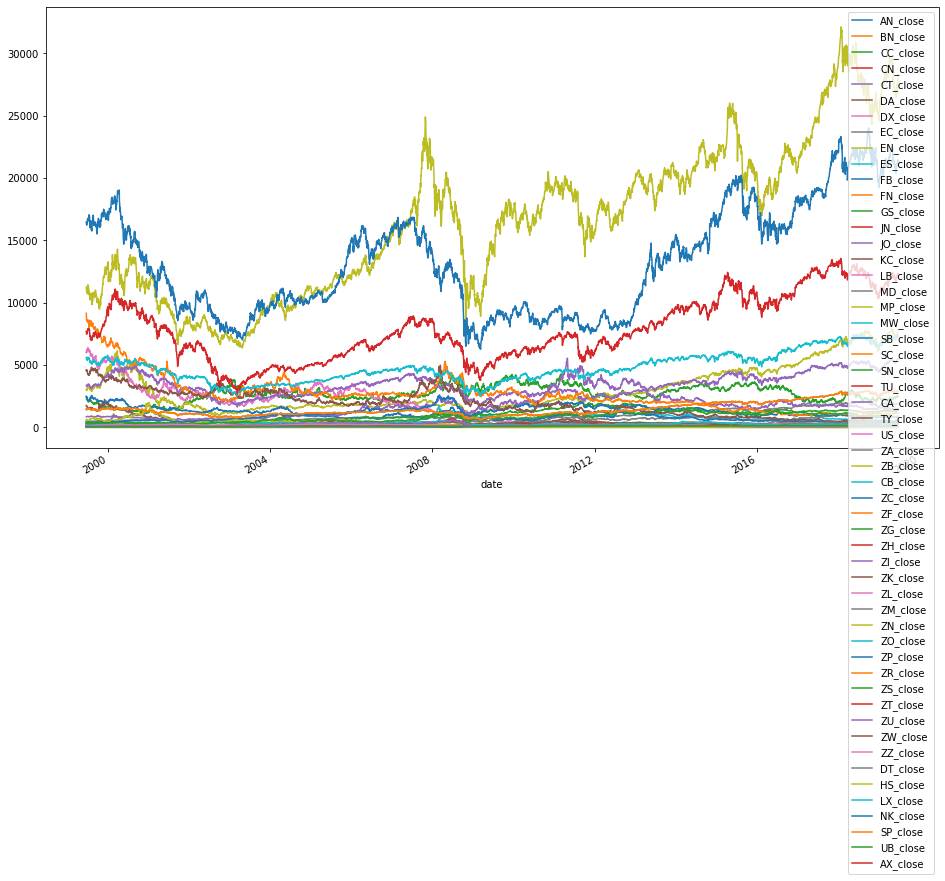

In [5]:
close_df.plot(figsize=(16,9))

# Retornos

Calculando os retornos diários, e mensais

In [6]:
# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(20).fillna(0).resample('BM').last().ffill()

In [7]:
returns_monthly.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-07-30,-0.021189,0.027540,-0.036536,-0.026502,-0.023546,0.225436,-0.029160,-0.000898,-0.021701,-0.036184,...,0.057915,-0.001894,0.109267,-0.018399,-0.021324,-0.016784,-0.007313,-0.036115,-0.010875,-0.049923
1999-08-31,-0.018156,-0.009752,-0.088951,0.007060,-0.044586,-0.046805,0.003214,-0.001936,0.051176,-0.009011,...,0.072384,0.006645,0.056515,-0.005199,0.022540,-0.001041,-0.005709,-0.009013,-0.001482,0.033014
1999-09-30,0.019440,0.023623,0.082220,0.017450,0.035829,-0.052946,-0.012567,0.000425,0.006367,-0.027313,...,0.109586,-0.023030,0.044980,-0.007839,-0.067142,-0.033892,-0.001976,-0.027490,-0.001608,-0.031337
1999-10-29,-0.032102,-0.003557,-0.169066,-0.007434,-0.031499,-0.104911,0.000806,-0.000586,0.076889,0.063359,...,-0.106911,-0.104987,-0.001076,0.000416,0.028891,0.040530,0.041638,0.063277,-0.004831,0.076805


# Volatilidades

Calculando volatilidades

- EWMA: Exponential weighted moving average, volatilidade com maior pesos nos dias mais recentes, no caso 60 dias
- Parkinson number: Estimativa de vol com preços de alta e baixa
- Garman-Klass: Estimativa de vol com preço: alta, baixa, abertura e fechamento.

## EWMA

In [8]:
# Vol diária
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

# Vol de 261 dias, apenas o último dia de cada mês
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

In [9]:
vol_monthly.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.099657,0.058628,0.326745,0.074062,0.194569,0.109147,0.053404,0.006329,0.254981,0.159787,...,0.355438,0.135659,0.368062,0.068701,0.205930,0.084750,0.091042,0.159730,0.030139,0.118389
1999-07-30,0.100956,0.090961,0.362069,0.052317,0.244505,0.225781,0.071222,0.004359,0.268479,0.149467,...,0.297552,0.278549,0.407706,0.072081,0.306736,0.220881,0.185948,0.149252,0.040948,0.215890
1999-08-31,0.100265,0.086400,0.315477,0.065318,0.231420,0.260459,0.081524,0.005153,0.281176,0.172133,...,0.288673,0.253385,0.380643,0.071235,0.311757,0.219495,0.190226,0.171941,0.040428,0.220648
1999-09-30,0.098584,0.082446,0.350053,0.060984,0.228155,0.269823,0.079807,0.005873,0.293490,0.185291,...,0.269880,0.259462,0.351287,0.074840,0.292105,0.208371,0.183706,0.185418,0.043175,0.215401
1999-10-29,0.101519,0.082757,0.328539,0.055669,0.217601,0.296536,0.086697,0.006815,0.308028,0.216552,...,0.376301,0.246463,0.350727,0.075301,0.328296,0.212098,0.189295,0.216482,0.043146,0.212663


### Parkinson number

Estimativa de volatilidade a partir dos preço de Alta e de Baixa

![Número de Parkinson](images/parkinson_vol.png)

In [10]:
def parkinson_vol(high_df, low_df, period=60):
    """
    Estimando a volatilidade a partir dos preço de Alta e de Baixa
    """
    
    # Calculando parcela interna da somatoria
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    pv = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1 / (4 * period * np.log(2))
    
    # Atribuindo not a number, para os valores iniciais
    pv.iloc[:period,:] = np.nan
        
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

In [11]:
pv_df = parkinson_vol(high_df, low_df)
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()

pv_monthly.head()

,AN_pv,BN_pv,CC_pv,CN_pv,CT_pv,DA_pv,DX_pv,EC_pv,EN_pv,ES_pv,...,ZU_pv,ZW_pv,ZZ_pv,DT_pv,HS_pv,LX_pv,NK_pv,SP_pv,UB_pv,AX_pv
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-09-30,0.099552,0.080792,0.315857,0.050618,0.202873,0.243479,0.061908,0.005640,0.279054,0.172749,...,0.235561,0.215090,0.335145,0.069490,0.163150,0.180401,0.084729,0.147775,0.039878,0.175627
1999-10-29,0.094599,0.079470,0.310301,0.047501,0.187113,0.259965,0.061020,0.005203,0.295026,0.194137,...,0.241094,0.217622,0.296288,0.063695,0.163058,0.184440,0.086341,0.161423,0.037080,0.180752


## Garman and Klass volatility

Estimativa de volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento

![Garman Klass vol](images/garman-klass_vol.png)

In [12]:
def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    """
    # Calculando parcelas internas da somatoria
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    # Somando parcelas calculadas
    x = x_hl + x_co.values
    
    x.columns = [x[0:3] + "gk" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    gk = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1/period
    
    # Atribuindo not a number, para os valores iniciais
    gk.iloc[:period,:] = np.nan
    
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

In [13]:
gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

gk_monthly.head()

,AN_gk,BN_gk,CC_gk,CN_gk,CT_gk,DA_gk,DX_gk,EC_gk,EN_gk,ES_gk,...,ZU_gk,ZW_gk,ZZ_gk,DT_gk,HS_gk,LX_gk,NK_gk,SP_gk,UB_gk,AX_gk
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-09-30,0.097246,0.079514,0.313968,0.053086,0.204841,0.242893,0.062291,0.005631,0.273707,0.172755,...,0.236265,0.211568,0.343169,0.070644,0.145004,0.180593,0.087065,0.149394,0.039906,0.172406
1999-10-29,0.093327,0.078885,0.307924,0.049376,0.186758,0.263382,0.061887,0.005098,0.292936,0.189013,...,0.244624,0.210796,0.299139,0.063714,0.144744,0.182661,0.088807,0.161436,0.036958,0.174152


## Visualização das volatilidades

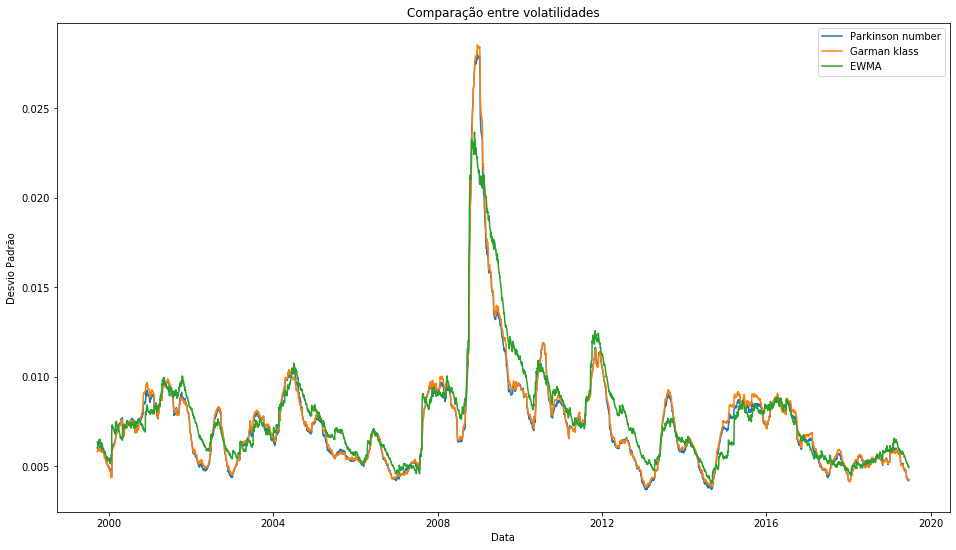

In [14]:
plt.figure(figsize=(16,9))

# Ativo que será plotada a comparação
asset = 0

plt.plot(pv_df.iloc[:,asset], label= "Parkinson number")
plt.plot(gk_df.iloc[:,asset], label="Garman klass")
plt.plot(vol_daily.iloc[60:,asset], label="EWMA")

plt.title("Comparação entre volatilidades")
plt.xlabel("Data")
plt.ylabel("Desvio Padrão")

plt.legend()
plt.show()

## Machine Learning Forecast

## Algorithm

![Generalização do TSMOM](images/ts_eq.png)

Onde $X_t$ é o sinal de predição, que esta entre -1 e 1

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor
from sklearn.ensemble     import RandomForestRegressor

In [77]:
def ml_signal(model, prices, lags=[3, 6, 12]):
    """
    Return predict and signal construction (long or short)
    """
    signal = []
    
    for i in prices.columns:
        # converting Series to DataFrame to do the feature engineering
        stock = pd.DataFrame(prices[i].copy())
        
        # renaming target variable
        stock.columns = ["y"]
        
        X = []
        y = []
        
        # adding lagged columns
        for i in lags:
            stock["lag_{}".format(i)] = stock.y.pct_change(i)
            
        y = stock[:-1].dropna().y                   # target
        X = stock[:-1].dropna().drop(['y'], axis=1) # features
        
        try:
        
            model.fit(X, y)

            X_pred = []
            for i in lags:
                X_pred.append(stock["lag_" + str(i)][-i])

            y_pred = model.predict([X_pred])

            sign = np.where(y_pred/stock.iloc[-1] - 1 > 0, -1, 1)
            
            signal.append(sign[0])
            
        except:
            
            signal.append(0)
        
        
    return signal

def signal(df, date, passive, method="momentum"):
    """
    Função que constrói o sinal para diversos metodos, sendo o tradicional: momentum
    """
        
    num_assets = len(df.iloc[-1])
    signal = []
    
    if passive:
        signal = np.ones(num_assets)
    else:
    
        if method == "momentum":

            returns = df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            signal = np.where(returns.iloc[-1] > 0, 1, -1)

        elif method == "momentum_lagged":

            returns_12 = df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            returns_6 = df.pct_change(21 * 6).resample('BM').last().ffill()[:date]

            returns_3 = df.pct_change(21 * 3).resample('BM').last().ffill()[:date]

            momentum_mean = (returns_12.iloc[-1] + returns_6.iloc[-1] + returns_3.iloc[-1]) / 3

            signal = np.where(momentum_mean > 0, 1, -1)
            
        elif method == "linear_regression":
            
            prices = df.resample('BM').last().ffill()[:date]
            
            lr = LinearRegression()
            
            signal = ml_signal(lr, prices)
            
        elif method == "random_forest":
            
            prices = df.resample('BM').last().ffill()[:date]
            
            rf = RandomForestRegressor()
            
            signal = ml_signal(rf, prices)
            
                
    return signal
    
def tsmom (df,returns_monthly, vol_monthly,date, method = 'momentum', risk=0.4, passive=False, momentum_window=12):
    
    position = signal(df, date, passive, method)
        
    weights = (risk / vol_monthly.iloc[date-1])
    
    weights /= len(weights)
    
    portfolio = position * weights
    
    return (1+np.dot(portfolio, returns_monthly.iloc[date]))

# Funções de backtesting e visualização

In [18]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def plot_backtesting(returns_model, returns_baseline, years, label_model, label_baseline, title):

    plt.figure(figsize=(16, 9))

    plt.plot(100*returns_model.cumprod(), label=label_model, color='blue')
    plt.plot(100*returns_baseline.cumprod(),
             label=label_baseline, color='red')

    plt.yscale('log')
    plt.legend()
    plt.title(title)
    plt.show()
    
    passive_return = float((returns_baseline.cumprod().iloc[-1] - 1)*100)
    tsmom_return = float((returns_model.cumprod().iloc[-1] - 1)*100)

    print('Passive ', label_baseline, ' return: ', round(passive_return,2), '%,',
         " Annualized: ", round((((100+passive_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')

    print('TSMOM ', label_model, ' return: ', round(tsmom_return,2), "%,",
         " Annualized: ", round((((100+tsmom_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')
    
def backtesting(close_df, vol_monthly, start_date, years, method, risk=0.4, plot=True):

    returns_model = []  
    returns_baseline = []
    sharpe = []
    
    start = start_date
    years = years
    end = 12*(int(start/12) + years)


    for i in range(start, end):
        
        printProgressBar (iteration=i-start, total=end-start-1)
        
        returns_model.append(tsmom(close_df, returns_monthly, vol_monthly, i, method, risk))

        returns_baseline.append(tsmom(close_df, returns_monthly, vol_monthly, i, risk, passive=True))

    returns_model = pd.DataFrame(returns_model)
    returns_baseline = pd.DataFrame(returns_baseline)

    returns_model.index = returns_monthly.iloc[start:end].index
    returns_baseline.index = returns_monthly.iloc[start:end].index

    if plot:
        plot_backtesting(returns_model, returns_baseline, years, method, "Long only", "Cumulative returns")
        
    return [returns_model, returns_baseline]

# Backtesting

## Classic TSMOM

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


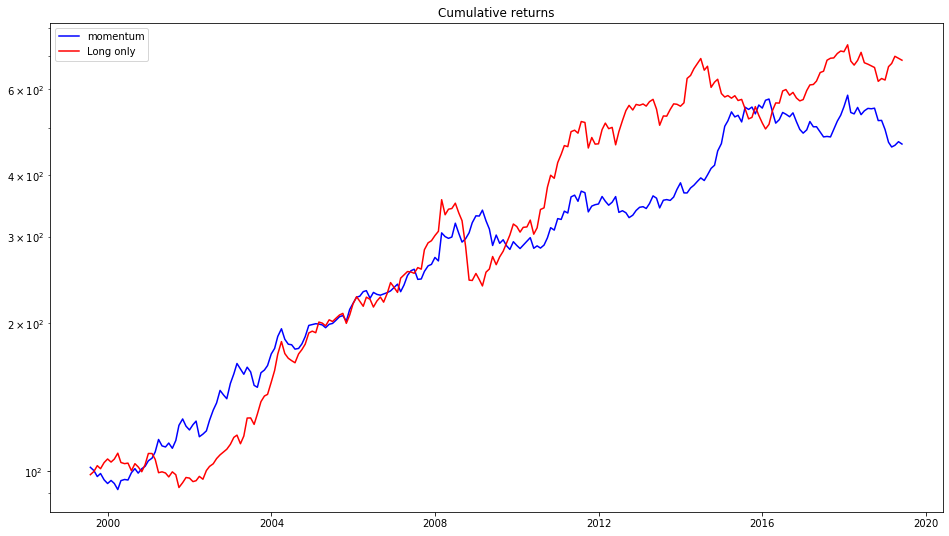

Passive Long only return: 586.8%, Annualized: 10.11%
TSMOM momentum return: 363.47%, Annualized: 7.97%


In [58]:
r_cl, rp_cl = backtesting(close_df, vol_monthly, start_date = 1, years=20,risk=0.4, method="momentum", plot=True);

## Parkinson vol

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


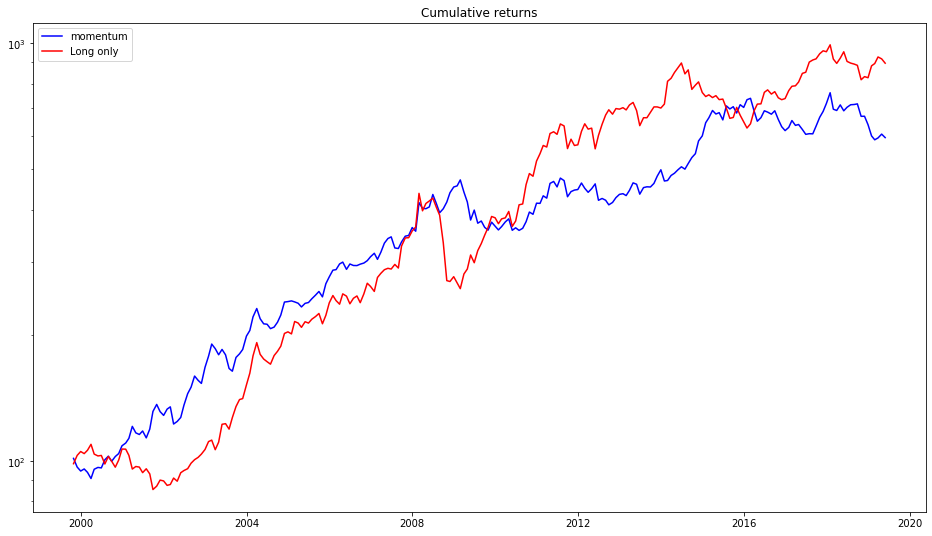

Passive Long only return: 796.32%, Annualized: 11.59%
TSMOM momentum return: 494.69%, Annualized: 9.32%


In [59]:
backtesting(close_df, pv_monthly, start_date = 1, years=20, risk = 0.4, method="momentum", plot=True);

## Garman klass vol

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


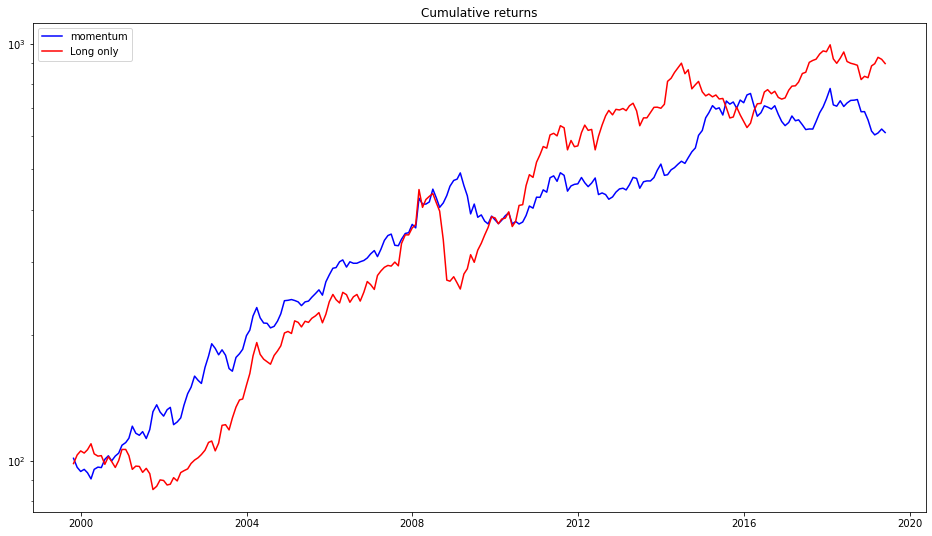

Passive Long only return: 795.9%, Annualized: 11.59%
TSMOM momentum return: 512.28%, Annualized: 9.48%


In [60]:
backtesting(close_df, gk_monthly, start_date= 1, years=20,risk=0.4, method="momentum", plot=True);

# Multiple mometums as signals

## Classic mometum vol

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


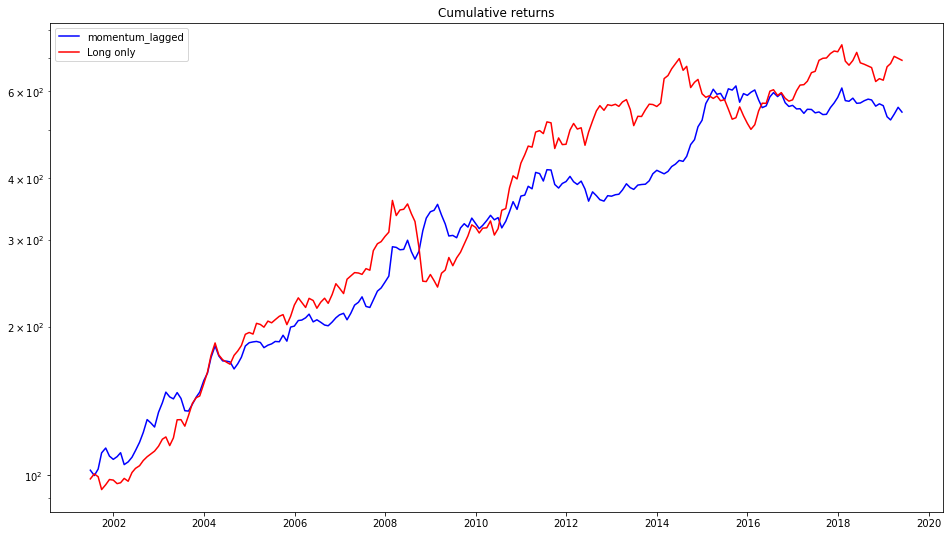

Passive Long only return: 593.4%, Annualized: 11.36%
TSMOM momentum_lagged return: 444.41%, Annualized: 9.87%


In [86]:
backtesting(close_df, vol_monthly, start_date= 24, years=18, risk=0.4, method="momentum_lagged", plot=True);

## Parkinson number

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


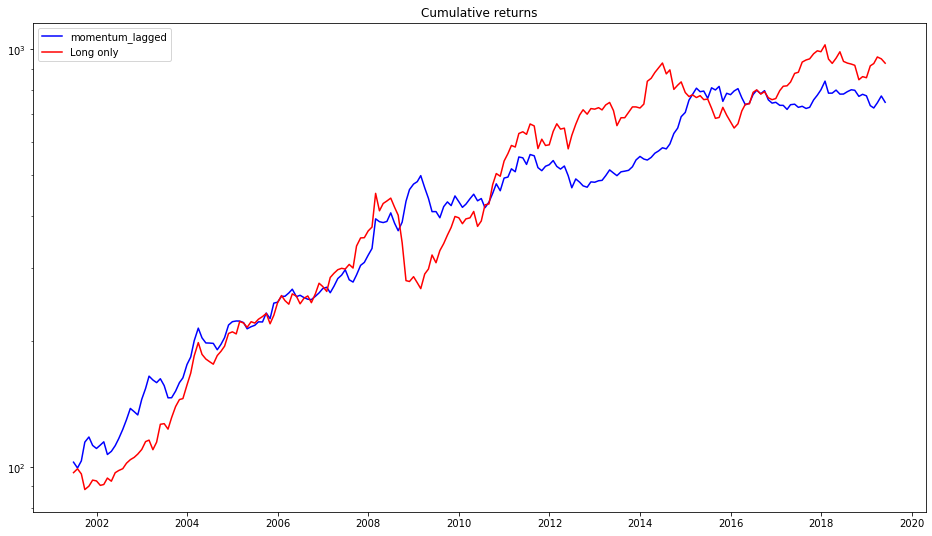

Passive Long only return: 826.88%, Annualized: 13.17%
TSMOM momentum_lagged return: 647.14%, Annualized: 11.82%


In [87]:
backtesting(close_df, pv_monthly, start_date= 24, years=18, risk=0.4, method="momentum_lagged", plot=True);

## Garman Klass

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


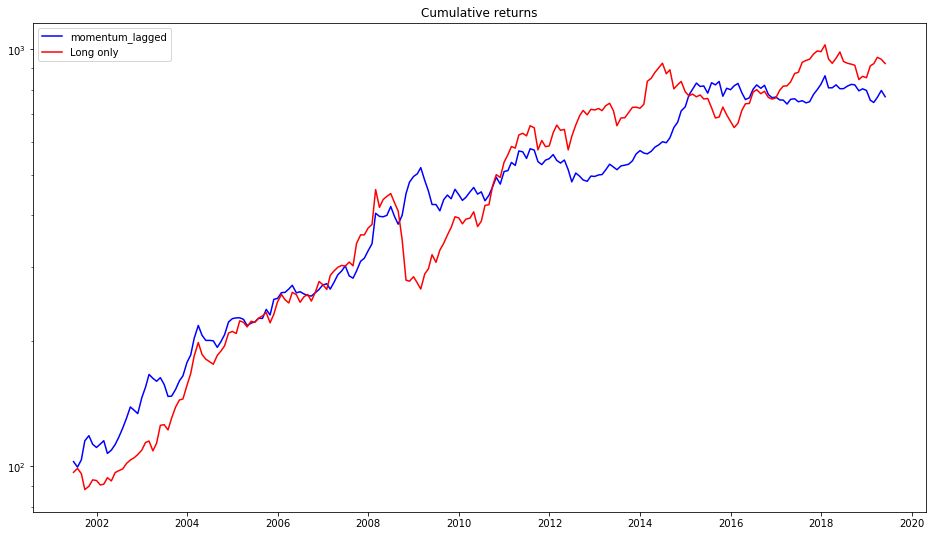

Passive Long only return: 823.58%, Annualized: 13.15%
TSMOM momentum_lagged return: 669.16%, Annualized: 12.0%


In [88]:
r_gk,rp_gk = backtesting(close_df, gk_monthly, start_date= 24, years=18, risk=0.4, method="momentum_lagged", plot=True);

# Machine Learning

## Linear Regression

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


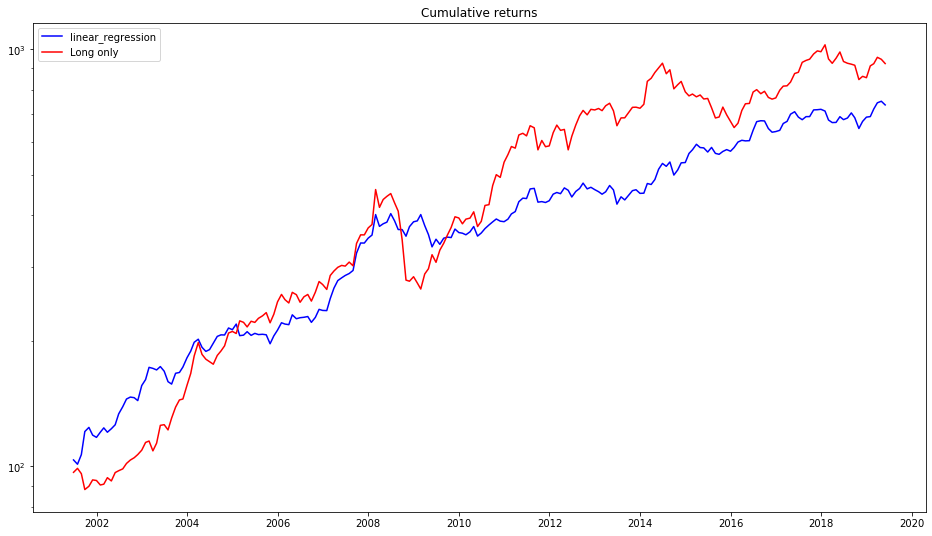

Passive Long only return: 823.58%, Annualized: 13.15%
TSMOM linear_regression return: 635.12%, Annualized: 11.72%


In [85]:
backtesting(close_df, gk_monthly, start_date= 24, years=18, method="linear_regression", risk=0.4, plot=True);

## Decision Tree

In [ ]:
backtesting(close_df, vol_monthly, start_date= 36, years=15, method="decision_tree", plot=True)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


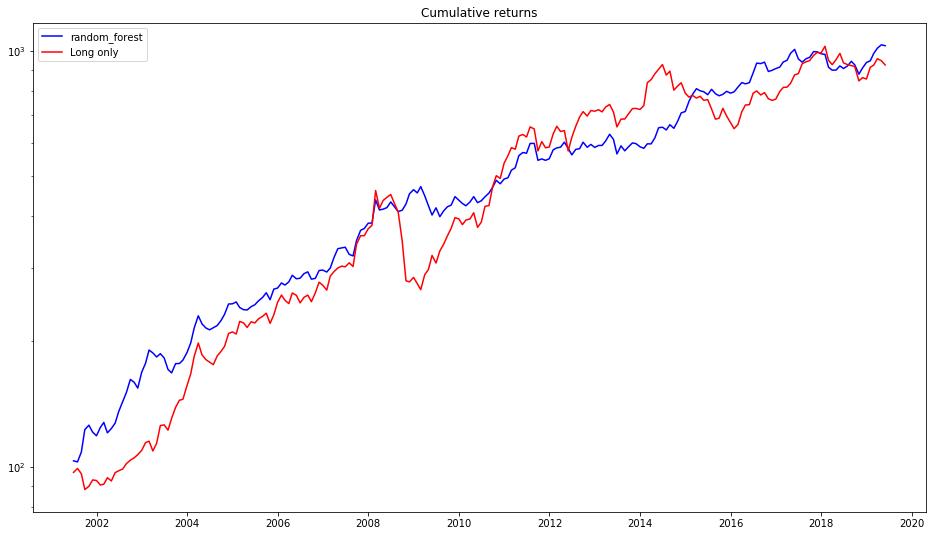

Passive Long only return: 823.58%, Annualized: 13.15%
TSMOM random_forest return: 927.28%, Annualized: 13.82%


In [90]:
r_rf, rp_rf = backtesting(close_df, gk_monthly, start_date= 24, years=18, method="random_forest", risk=0.4, plot=True)

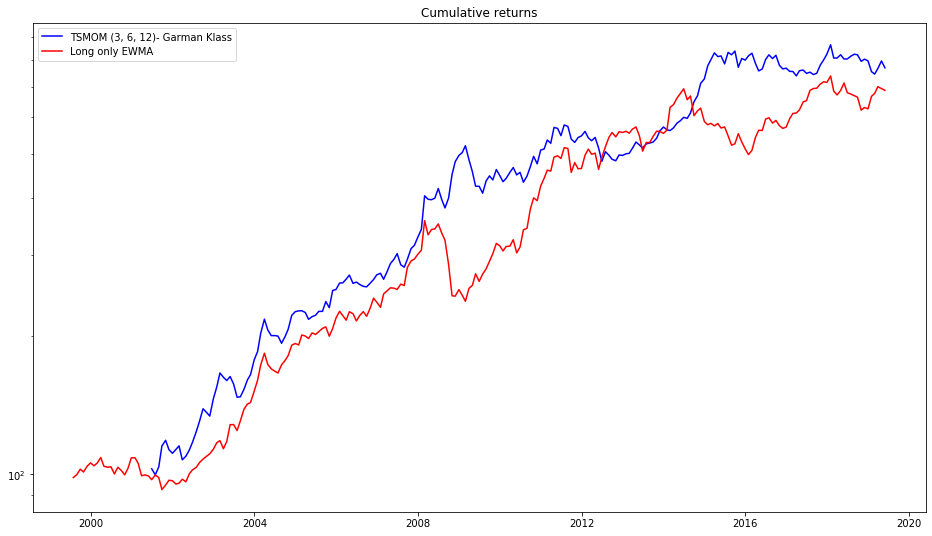

Passive Long only EWMA return: 586.8%, Annualized: 10.67%
TSMOM TSMOM (3, 6, 12)- Garman Klass return: 669.16%, Annualized: 11.34%


In [91]:
plot_backtesting(r_gk, rp_cl, 
                 years=19, 
                 label_model="TSMOM (3, 6, 12)- Garman Klass", 
                 label_baseline="Long only EWMA", 
                 title="Cumulative returns")